In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
import glob
import xarray as xr

scenario = "ssp585"
ensemble = "r1i1p1f1"

inpath = "/work/uo1227/u301557/DL/data/"

SIA = xr.open_dataset(f"{inpath}/sia/sia_nh_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")
CO2 = xr.open_dataset(f"{inpath}/co2_emissions.nc")
SST = xr.open_dataset(f"{inpath}/sst/tos_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")
GMST = xr.open_dataset(f"{inpath}/gmst/tas_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")

In [3]:
co2  = CO2[scenario].cumsum().values[100:]
sst  = SST.tos.isel(time=slice(8,-1,12)).values[:,0,0] #select september
gmst = GMST.tas.isel(time=slice(8,-1,12)).values[:,0,0]
sia  = SIA.sia_nh.isel(time=slice(8,-1,12)).values[:]
print(co2.shape,sst.shape,gmst.shape,sia.shape)

(251,) (251,) (251,) (251,)


In [4]:
if True:
    co2_norm  = (co2 - np.mean(co2))/np.std(co2)
    sst_norm  = (sst - np.mean(sst))/np.std(sst)
    gmst_norm = (gmst - np.mean(gmst))/np.std(gmst)
    sia_norm  = (sia - np.mean(sia))/np.std(sia)
else:
    co2_norm  = (co2)/np.max(co2)
    sst_norm  = (sst)/np.max(sst)
    gmst_norm = (gmst)/np.max(gmst)
    sia_norm  = (sia)/np.max(sia)

Vars = [co2_norm]

X = torch.tensor(np.stack(Vars,axis=1), dtype=torch.float32)
y = torch.tensor(sia_norm).view(-1, 1)
print(X.shape,y.shape)

X_train = X[:165]
X_test  = X[165:]
y_train = y[:165]
y_test  = y[165:]

print(X_train.shape,X_test.shape)

torch.Size([251, 1]) torch.Size([251, 1])
torch.Size([165, 1]) torch.Size([86, 1])


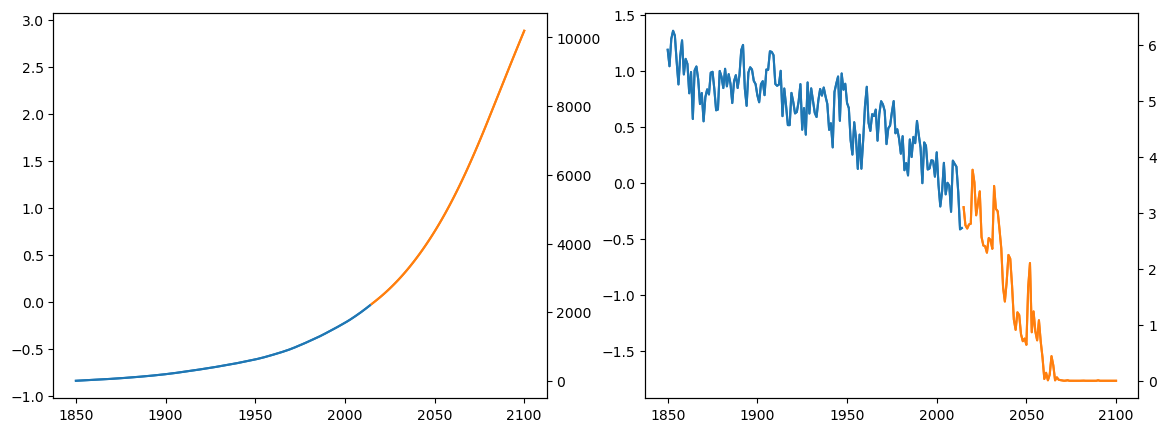

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,X.shape[1]+1) 

for i in range(axs.shape[0]-1):
    axs[i].plot(range(1850,2015),X_train[:,i])
    axs[i].plot(range(2015,2101),X_test[:,i])
    ax2 = axs[i].twinx()
    ax2.plot(range(1850,2015),np.mean(co2)+X_train[:,i]*np.std(co2))
    ax2.plot(range(2015,2101),np.mean(co2)+X_test[:,i]*np.std(co2))
    
axs[-1].plot(range(1850,2015),y_train[:])
axs[-1].plot(range(2015,2101),y_test[:])
ax2 = axs[-1].twinx()
ax2.plot(range(1850,2015),np.mean(sia)+y_train[:]*np.std(sia))
ax2.plot(range(2015,2101),np.mean(sia)+y_test*np.std(sia))

plt.show()

In [6]:
# Define your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the output of the last time step
        return output

In [7]:
# Set hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 50
learning_rate = 0.001


In [8]:
# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

w = 1
for epoch in range(num_epochs):
    # Forward pass
    for t in range(len(X_train)-w):
        output = model(X_train[t:t+w])
        #print()
        loss = criterion(output, y_train[t+w])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/50], Loss: 0.1532
Epoch [20/50], Loss: 0.0859
Epoch [30/50], Loss: 0.0834
Epoch [40/50], Loss: 0.0820
Epoch [50/50], Loss: 0.0806


In [9]:
# Predict the sea ice area for the test data
predicted_sea_ice_area = []

# Initialize the initial input with the last training data point
input_data = X_train[-1].unsqueeze(0)

# Iterate over the test CO2 emissions data and predict the sea ice area for each year
for i in range(len(X_test)):
    output = model(input_data)
    predicted_sea_ice_area.append(output.item())

    # Prepare the input for the next time step
    input_data = torch.tensor([[X_test[i]]], dtype=torch.float32)

# De-normalize the predicted sea ice area
predicted_sea_ice_area = (np.array(predicted_sea_ice_area)* np.std(sia) + np.mean(sia))


In [10]:
# Predict the sea ice area for the test data
train_yhat = []

# Iterate over the test CO2 emissions data and predict the sea ice area for each year
for i in range(len(X_train)):
    output = model(X_train[i].unsqueeze(0))
    train_yhat.append(output.item())

# De-normalize the predicted sea ice area
train_yhat = (np.array(train_yhat)* np.std(sia) + np.mean(sia))


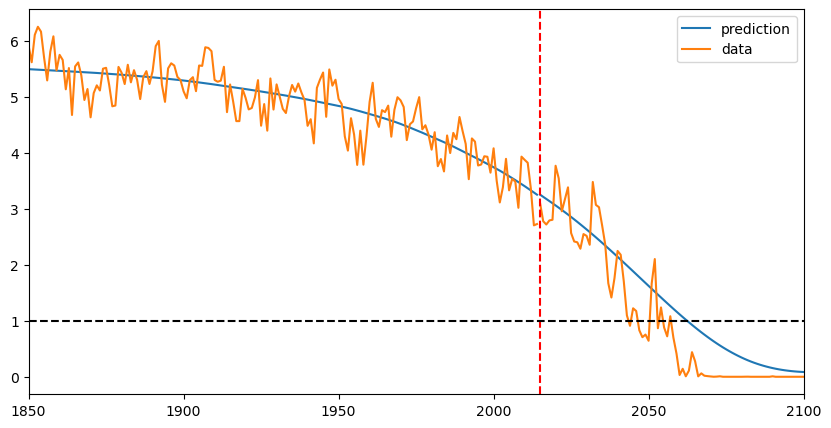

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1)

ax.plot(range(1850,2015),train_yhat,label="prediction",c='#1f77b4')#, '#ff7f0e')
ax.plot(range(1850,2015),y_train*np.std(sia)+np.mean(sia),label="data",c='#ff7f0e')
ax.plot(range(2015,2101),predicted_sea_ice_area,c='#1f77b4')
ax.plot(range(2015,2101),y_test*np.std(sia)+np.mean(sia),c='#ff7f0e')
#ax.set_ylim(0,7)

ax.axvline(x=2015, c='r', linestyle='--') #size of the training set
ax.axhline(y=1, c='black', linestyle='--') #size of the training set
ax.margins(x=0)
ax.legend()
plt.show()